In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

def b_maxL_2(m, t, C):
    first = C[0]+C[1]-(m[0]+m[1])*(t[0]+t[1])
    root = (C[0]+C[1]+(m[0]-m[1])*(t[0]+t[1]))**2-4*C[0]*(m[0]-m[1])*(t[0]+t[1])
    res = (first+np.sqrt(root))/(2*(t[0]+t[1]))
    if res < 0:
        return 0
    return res

In [72]:
# true incoming rates
s1 = 200.
s2 = 1000.
b = 300.

# include time, even though rates = counts here, only included so that b_max_L doesn't have to be rewritten
t1 = 1.
t2 = 1.

true_counts = np.array([s1, s2, b, b])
cluster_size = 2

# How many posterior samples
num_posterior_samples = 300
# How many predictive samples, equivalent to number of real data bins in real analysis
num_predictive_samples = 10000
# Bins in plot
num_bins = 50

# standard deviation of posterior
posterior_std = np.array([50., 50.])
# samples of posterior
posterior_samples = np.random.normal(true_counts[:cluster_size], posterior_std, size=(num_posterior_samples, cluster_size))

# Each posterior sample is sampled into the predictive samples
posterior_predictive_source_counts = np.random.poisson(posterior_samples, (num_predictive_samples, num_posterior_samples, cluster_size))
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(0, 1)
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(1, 2)

# actual measured counts, available to use in analysis
measured_counts = np.random.poisson(true_counts, (num_predictive_samples, len(true_counts)))
measured_counts_combined = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

# maximum likelihood background
b_max_L = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_posterior_samples):
    for j in range(num_predictive_samples):
        b_max_L[j, i] = b_maxL_2(posterior_samples[i], [t1, t2], measured_counts_combined[j])
# _ = plt.hist(b_max_L, bins=num_bins)


In [73]:
# Repeat for easier usage
posterior_predictive_background_counts = np.repeat(b_max_L[:,:,np.newaxis], 2, axis=2)
# Sample posterior predictive counts
posterior_predictive_counts = np.random.poisson(posterior_predictive_background_counts + posterior_predictive_source_counts)

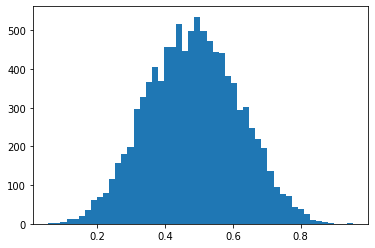

In [74]:
# Sort posterior predictive counts for each predictive sample, i.e. sort posterior samples
argsort = np.argsort(posterior_predictive_counts, axis=1)
total = np.take_along_axis(posterior_predictive_counts, argsort, axis=1)

# Find placement of measured counts in sorted array
cdf = np.zeros(num_predictive_samples)
for i in range(num_predictive_samples):
    cdf[i] = ((np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "left")
                     + np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "right"))
                     / (2 * num_posterior_samples))
    
_ = plt.hist(cdf, bins=num_bins)
